Nesse código a princípio a ideia é conseguir calcular as forças que atuam numa partícula presa em uma pinça óptica. Nele, quero tratar das forças de gradiente e de espalhamento geradas pela interação dessa partícula com o campo elétrico de um feixe de laser. Por hora, tenho aqui apenas o feixe Gaussiano, que pode ser escolhido tanto como feixe único se propagando ao longo de z, como um feixe composto por dois feixes contrapropagantes, gerando assim uma onda estacionária. Futuramente, além dessas opções, quero adicionar também feixes estruturados e composições de diversos deles.

A quem tiver esse código em mãos, sintam-se a vontade para usá-lo. Estou tentando mantê-lo bem organizado, comentado, e o mais simples e completo possível.

Ass.: Ariel Hertz :D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite

CORREÇÃO PARA NA ALTO: LIVRO DO NOVOTNY (NANO OPTICS) CAPÍTULO 3 (NECESSÁRIO IMPLEMENTAR)

In [2]:
c = 3.0e8  # (m/s)
density = 2200  # kg/m³ (SiO2)
kB = 1.38e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 75e-9  # particle radius (m)
T = 300 # K
lamb = 780e-9  # (m)
NA = 0.4
P = 50e-3 # Total Power (W)
m_gas = 4.81e-26 # molecular mass of air
Pressure = 1013.25 #mbar (1 atm)

In [3]:
k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
m_rri = n_p/n_md #relative refractive index
z_R = (np.pi * w_0**2) / lamb #rayleigh range
volume = (4/3) * np.pi * R**3
m = density * volume  # kg
v_0p = np.sqrt(3*kB*T/m) #velocidade térmica média da nanopartícula

In [4]:
def Gamma_chang(radius, Pressure_mbar): #essa pressão foi uma função retirada do repositório https://github.com/AshleySetter/optoanalysis/blob/master/Damping_radius_relation.ipynb
    Press = 100*Pressure_mbar
    ave_velocity = (8*kB*T/(np.pi*m_gas))**(1/2)
    Gamma0 = 8*Press/(np.pi*ave_velocity*radius*density)/2
    return 2*Gamma0

gamma = Gamma_chang(R,Pressure)

D = kB*T/gamma

def R_curv(z):
    z_safe = np.where(z == 0, 1e-40, z)       #Isso aqui impede que o código quebre em z = 0 substituindo esse
    return z_safe*(1+((z_R**2)/(z_safe**2)))  #ponto por um outro valor muito pequeno diferente de zero.

def gouy_phase(z):
    return np.arctan(z/z_R)

def w(z):
    return w_0*((1+((z**2)/(z_R**2)))**(1/2))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

CORRIGIR OS MODOS HERMITE E ADICIONAR OS MODOS LAGUERRE

In [ ]:
mode = 'G'
prop = 'counter'
discr = [0]

if mode == 'G':
    if prop == 'single':
        def E(x,y,z,discr):  #single gaussian beam
            return (np.sqrt(P/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))

    elif prop == 'counter':
        def E(x,y,z,discr): #two counterpropagating gaussian beams
            E1 = (np.sqrt((P/2)/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))
            E2 = (np.sqrt((P/2)/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))
            return E1+E2
        
elif mode == 'HG':
    def E(x,y,z,discr):
        EG = (np.sqrt(P/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*z+k*((x**2))+((y**2)/(2*R_curv(z))) - gouy_phase(z)))
        
        m = discr[0]
        n = discr[1]
        
        hermite_x = np.sqrt(2) * x * w(z)
        hermite_y = np.sqrt(2) * y * w(z)

        Hm = hermite(m)(hermite_x)
        Hn = hermite(n)(hermite_y)

        E = EG*Hm*Hn*np.exp(-1j*(m+n)*gouy_phase(z))
        return E

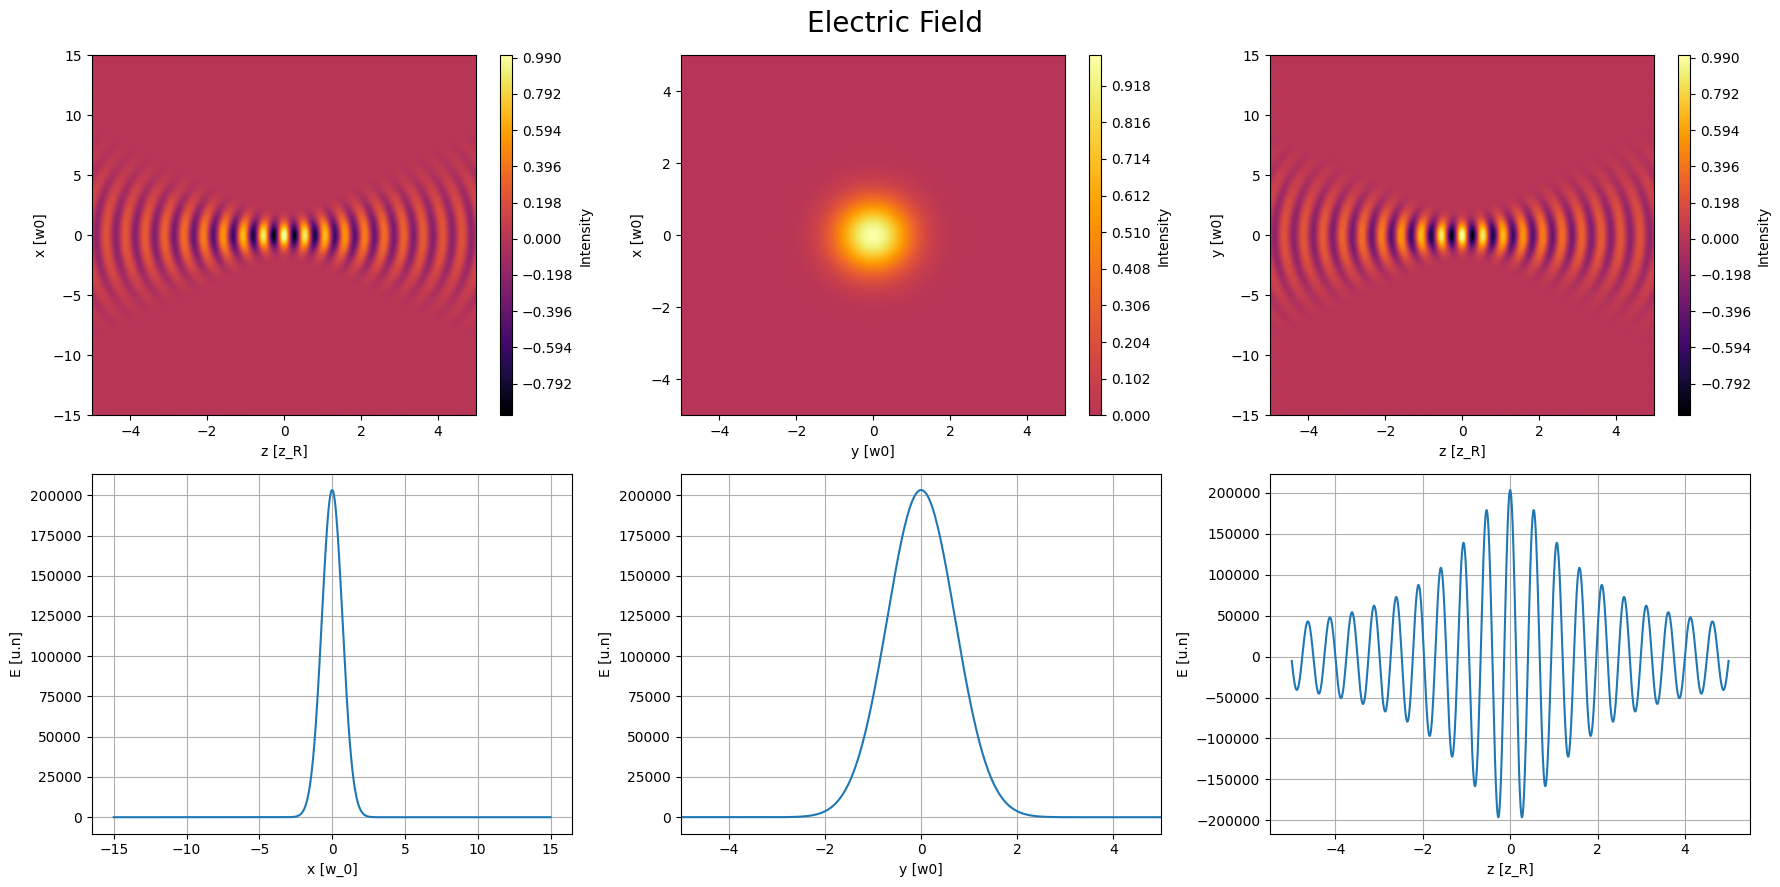

In [ ]:
x = np.linspace(-15*w_0,15*w_0,1000)
y = np.linspace(-15*w_0,15*w_0,1000)
z = np.linspace(-5*z_R,5*z_R,2000)
E_max = E(0,0,0,discr).real

fig, axs = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Electric Field",fontsize=20)

def norm_E(): #apenas define a normalização das escalas de cor dos plots do campo E
    X, Z = np.meshgrid(x, z)
    E_val_XZ = E(X, 0, Z, discr).real / E_max
    X, Y = np.meshgrid(x, y)
    E_val_XY = E(X, Y, 0, discr).real / E_max
    Y, Z = np.meshgrid(y, z)
    E_val_YZ = E(0, Y, Z, discr).real / E_max
    
    Emin = min(E_val_XZ.min(), E_val_XY.min(), E_val_YZ.min())
    Emax = max(E_val_XZ.max(), E_val_XY.max(), E_val_YZ.max())
    
    return Emin,Emax

X,Z = np.meshgrid(x,z)
E_XZ = E(X,0,Z,discr).real
contour = axs[0,0].contourf(Z/z_R, X/w_0, E_XZ/E_max, levels=350, cmap="inferno", vmin = norm_E()[0], vmax = norm_E()[1])
#contour = axs[0,0].contourf(Z/z_R, X/w_0, E_XZ, levels=350, cmap="inferno")
fig.colorbar(contour, ax=axs[0,0], label="Intensity", aspect = 30)
axs[0,0].set_xlabel("z [z_R]")
axs[0,0].set_ylabel("x [w0]")

X,Y = np.meshgrid(x,y)
E_XY = E(X,Y,0,discr).real
contour = axs[0,1].contourf(Y/w_0, X/w_0, E_XY/E_max, levels=350, cmap="inferno", vmin = norm_E()[0], vmax = norm_E()[1])
#contour = axs[0,1].contourf(Y/w_0, X/w_0, E_XY, levels=350, cmap="inferno")
fig.colorbar(contour, ax=axs[0,1], label="Intensity", aspect = 30)
axs[0,1].set_xlabel("y [w0]")
axs[0,1].set_ylabel("x [w0]")
axs[0,1].set_xlim(-5,5)
axs[0,1].set_ylim(-5,5)

Y,Z = np.meshgrid(y,z)
E_YZ = E(0,Y,Z,discr).real
contour = axs[0,2].contourf(Z/z_R, Y/w_0, E_XZ/E_max, levels=350, cmap="inferno", vmin = norm_E()[0], vmax = norm_E()[1])
#contour = axs[0,2].contourf(Z/z_R, Y/w_0, E_XZ, levels=350, cmap="inferno")
fig.colorbar(contour, ax=axs[0,2], label="Intensity", aspect = 30)
axs[0,2].set_xlabel("z [z_R]")
axs[0,2].set_ylabel("y [w0]")

axs[1,0].plot(x/w_0,E(x,0,0,discr).real)
axs[1,0].set_xlabel("x [w_0]")
axs[1,0].set_ylabel("E [u.n]")
axs[1,0].grid(True)

axs[1,1].plot(y/w_0,E(0,y,0,discr).real)
axs[1,1].set_xlabel("y [w0]")
axs[1,1].set_ylabel("E [u.n]")
axs[1,1].set_xlim(-5,5)
axs[1,1].grid(True)

axs[1,2].plot(z/z_R,E(0,0,z,discr).real)
axs[1,2].set_xlabel("z [z_R]")
axs[1,2].set_ylabel("E [u.n]")
axs[1,2].grid(True)

plt.tight_layout()
plt.savefig("Electric_field_counter.pdf", format='pdf', dpi=3000)
plt.show()

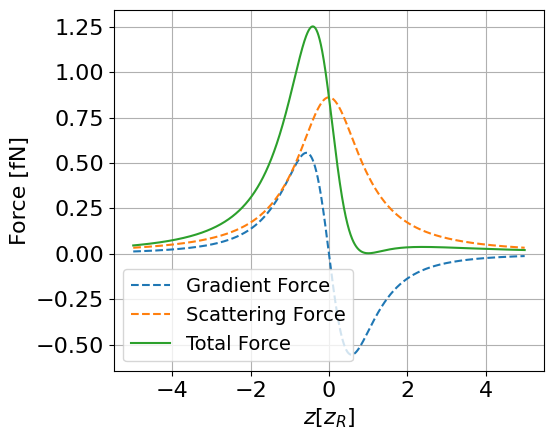

In [7]:
I_x, I_y, I_z = I(E(x, 0, 0,discr)), I(E(0, y, 0,discr)), I(E(0, 0, z,discr))

F_scatt_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2)+2))**2)*I_z

F_grad_x = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2 )-1)/((m_rri**2)+2))*np.gradient(I_x, x)
F_grad_y = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_y, y)
F_grad_z = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z, z)

#fig, axs = plt.subplots(1, 3, figsize=(18, 6),sharey=True)
#fig.suptitle("Force Relations", fontsize=27)
tamanho_leg = 16
plt.figure(figsize=(5.5,4.5))

#axs[0].plot(x/w_0, 10e15*(F_grad_x), label = "Total Force (Gradient)")
#axs[0].grid(True)
#axs[0].set_xlabel("x [w0]",fontsize=tamanho_leg)
#axs[0].set_ylabel("Force [fN]",fontsize=tamanho_leg)
#axs[0].set_xlim(-5,5)
#axs[0].tick_params(axis='x', labelsize=tamanho_leg)
#axs[0].tick_params(axis='y', labelsize=tamanho_leg)
#
#axs[1].plot(y/w_0, 10e15*(F_grad_y), label = "Total Force")
#axs[1].grid(True)
#axs[1].set_xlabel("y [w0]", fontsize=tamanho_leg)
#axs[1].set_xlim(-5,5)
#axs[1].tick_params(axis='x', labelsize=tamanho_leg)
#
#axs[2].plot(z/z_R, 10e15*F_grad_z, '--', label = "Gradient Force")
#axs[2].plot(z/z_R, 10e15*F_scatt_z,'--', label = "Scattering Force")
#axs[2].plot(z/z_R, 10e15*(F_grad_z + F_scatt_z), label = "Total Force")
#axs[2].grid(True)
#axs[2].set_xlabel("z [zR]", fontsize=tamanho_leg)
#axs[2].tick_params(axis='x', labelsize=tamanho_leg)

plt.plot(z/z_R, 10e15*F_grad_z, '--', label = "Gradient Force")
plt.plot(z/z_R, 10e15*F_scatt_z,'--', label = "Scattering Force")
plt.plot(z/z_R, 10e15*(F_grad_z + F_scatt_z), label = "Total Force")
plt.grid(True)
plt.xlabel(r'$z [z_{R}]$', fontsize=tamanho_leg)
plt.ylabel("Force [fN]",fontsize=tamanho_leg)
plt.tick_params(axis='x', labelsize=tamanho_leg)
plt.tick_params(axis='y', labelsize=tamanho_leg)

#plt.grid(True)
plt.legend(fontsize=14,loc='lower left')
plt.tight_layout()
#plt.savefig("zforces_single_NA04.pdf", format='pdf', dpi=3000)
plt.show()